In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn import set_config

In [2]:
set_config(transform_output="pandas")

In [3]:
df = pd.read_csv("../data/customer_churn_processed_data.csv")
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   creditscore      10000 non-null  int64  
 1   country          10000 non-null  object 
 2   gender           10000 non-null  object 
 3   age              10000 non-null  int64  
 4   tenure           10000 non-null  int64  
 5   balance          10000 non-null  float64
 6   numofproducts    10000 non-null  int64  
 7   hascrcard        10000 non-null  int64  
 8   isactivemember   10000 non-null  int64  
 9   estimatedsalary  10000 non-null  float64
 10  exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB


### Split the data

In [4]:
X = df.drop("exited", axis=1)
y = df["exited"]

### Create feature transformer

In [5]:
numeric_cols = ["creditscore", "age", "tenure", "balance", "numofproducts", "estimatedsalary"]
cat_cols = ["gender", "country"]
preprocessor = ColumnTransformer(
    [
        ("cat", OneHotEncoder(sparse_output=False, drop="if_binary"), cat_cols),
        # ("scaler", StandardScaler(), numeric_cols)
    ],
    remainder="passthrough"
)
X_processed = preprocessor.fit_transform(X)
X_processed.head()

,cat__gender_male,cat__country_france,cat__country_germany,cat__country_spain,remainder__creditscore,remainder__age,remainder__tenure,remainder__balance,remainder__numofproducts,remainder__hascrcard,remainder__isactivemember,remainder__estimatedsalary
0,0.0,1.0,0.0,0.0,619,42,2,0.00,1,1,1,101348.88
1,0.0,0.0,0.0,1.0,608,41,1,83807.86,1,0,1,112542.58
2,0.0,1.0,0.0,0.0,502,42,8,159660.80,3,1,0,113931.57
3,0.0,1.0,0.0,0.0,699,39,1,0.00,2,0,0,93826.63
4,0.0,0.0,0.0,1.0,850,43,2,125510.82,1,1,1,79084.10


In [6]:
X_processed_scaled = StandardScaler().fit_transform(X_processed)

### Build kmeans model

In [7]:
inertias = []
sl_scores = []
n_clusters = range(2, 20)

for n_cluster in n_clusters:
    _kmeans = KMeans(n_cluster, random_state=42)
    _kmeans.fit(X_processed_scaled)
    _inertia = _kmeans.inertia_

    inertias.append(_inertia)
    sl_scores.append(silhouette_score(X_processed_scaled, _kmeans.labels_))

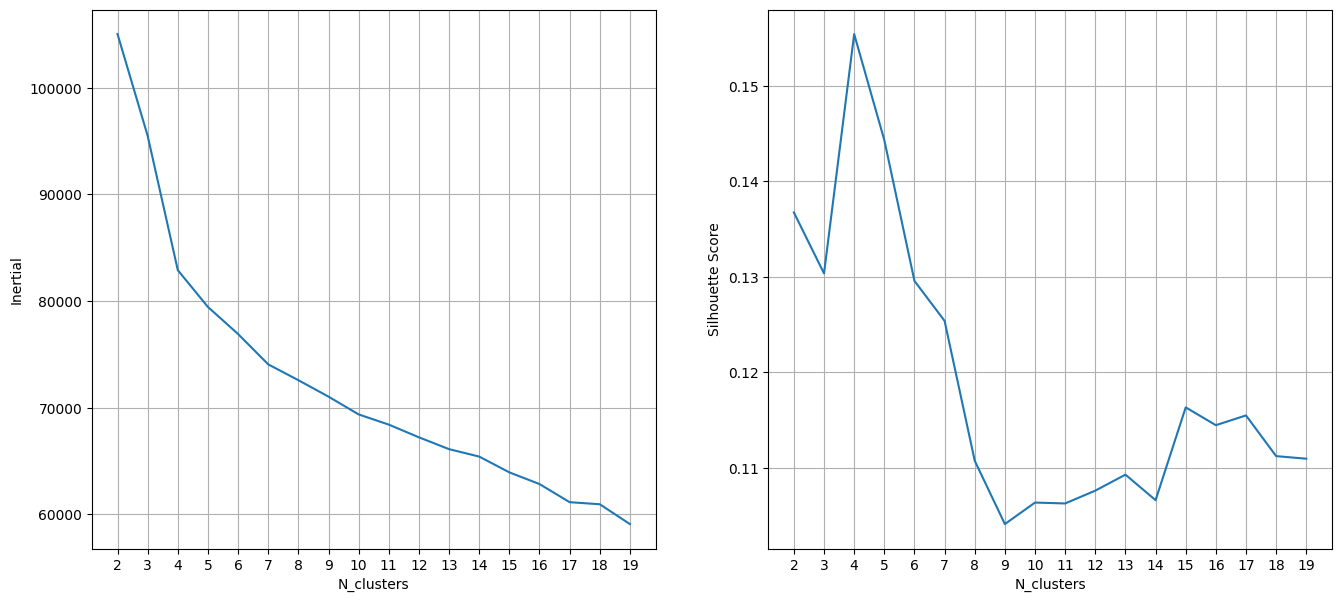

In [8]:
_, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].plot(n_clusters, inertias)
ax[1].plot(n_clusters, sl_scores)
ax[0].set_xlabel("N_clusters")
ax[0].set_ylabel("Inertial")
ax[1].set_xlabel("N_clusters")
ax[1].set_ylabel("Silhouette Score")
ax[0].set_xticks(n_clusters)
ax[1].set_xticks(n_clusters)
ax[0].grid()
ax[1].grid();

### Retrain kmeans with 4 clusters

In [9]:
kmeans = KMeans(n_clusters=4, random_state=42)
kmeans.fit(X_processed_scaled)

KMeans(n_clusters=4, random_state=42)

In [10]:
kmeans.inertia_

82884.89008510338

### Analyze the clusters

In [11]:
df_clustered = df.assign(cluster_label = kmeans.labels_)
df_clustered.head()

,creditscore,country,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,cluster_label
0,619,france,female,42,2,0.00,1,1,1,101348.88,1,1
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0,3
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1,2
3,699,france,female,39,1,0.00,2,0,0,93826.63,0,2
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0,3


In [12]:
samples_per_cluster = df_clustered["cluster_label"].value_counts()
samples_per_cluster

cluster_label
1    2951
0    2509
3    2477
2    2063
Name: count, dtype: int64

### Cluster vs Numeric cols

In [13]:
numeric_cols = ["creditscore", "age", "tenure", "balance", "numofproducts", "estimatedsalary"]

cluster_label
0    651.453567
1    648.369705
2    651.525933
3    651.333872
Name: creditscore, dtype: float64


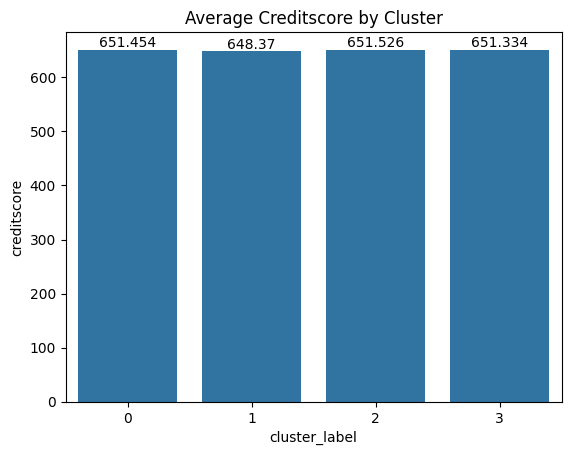

cluster_label
0    39.771622
1    39.089800
2    37.684925
3    38.890997
Name: age, dtype: float64


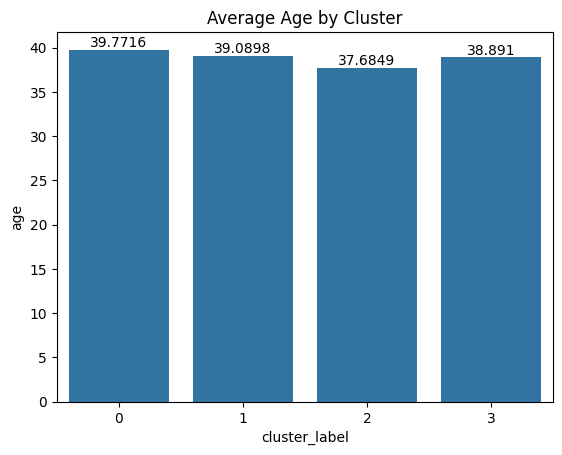

cluster_label
0    5.009964
1    4.957980
2    5.071255
3    5.032297
Name: tenure, dtype: float64


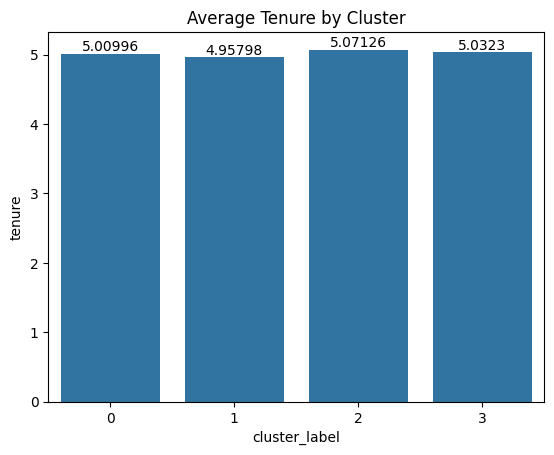

cluster_label
0    119730.116134
1     97598.515727
2     11303.567416
3     61818.147763
Name: balance, dtype: float64


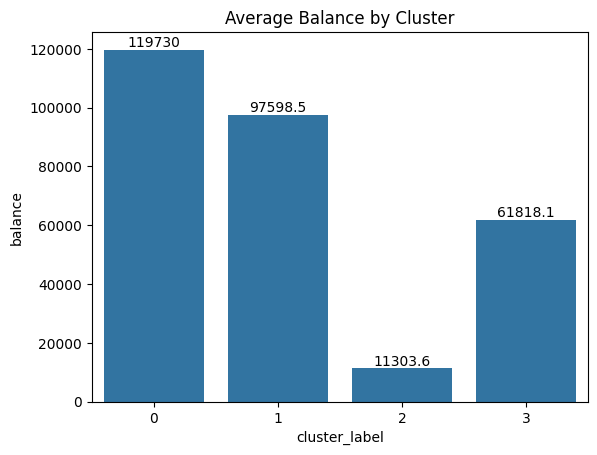

cluster_label
0    1.519729
1    1.148085
2    2.078526
3    1.539362
Name: numofproducts, dtype: float64


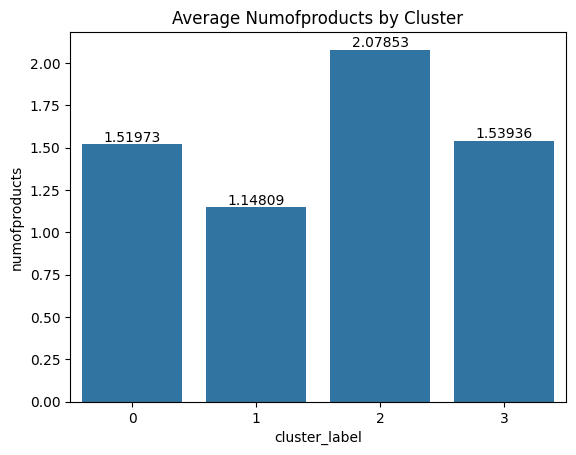

cluster_label
0    101113.435102
1     99404.522162
2    100606.760882
3     99440.572281
Name: estimatedsalary, dtype: float64


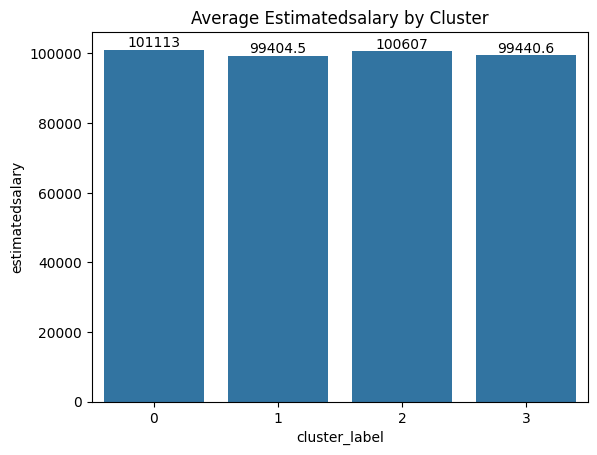

In [14]:
for col in numeric_cols:
    group_average = df_clustered.groupby("cluster_label")[col].mean()
    print(group_average)
    ax = sns.barplot(group_average)
    ax.bar_label(ax.containers[0])
    plt.title(f"Average {col.title()} by Cluster")
    plt.show()

#### Cluster vs categories

In [15]:
df_clustered.head()

,creditscore,country,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,cluster_label
0,619,france,female,42,2,0.00,1,1,1,101348.88,1,1
1,608,spain,female,41,1,83807.86,1,0,1,112542.58,0,3
2,502,france,female,42,8,159660.80,3,1,0,113931.57,1,2
3,699,france,female,39,1,0.00,2,0,0,93826.63,0,2
4,850,spain,female,43,2,125510.82,1,1,1,79084.10,0,3


In [16]:
categorical_cols = ["exited", "country", "gender", "hascrcard", "isactivemember"]

exited                0         1
cluster_label                    
0              0.675568  0.324432
1              0.790918  0.209082
2              0.906447  0.093553
3              0.833266  0.166734


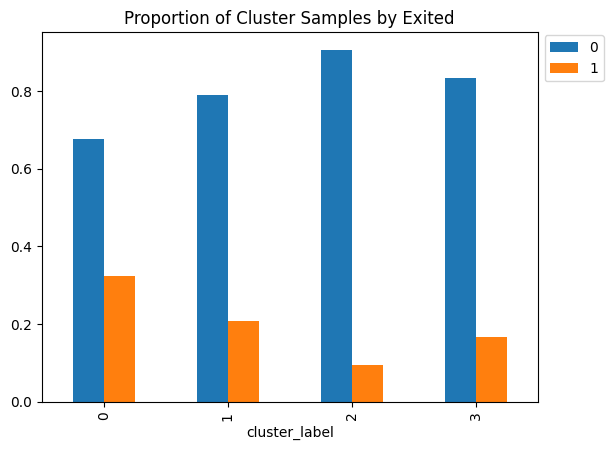

country        france  germany  spain
cluster_label                        
0                 0.0      1.0    0.0
1                 1.0      0.0    0.0
2                 1.0      0.0    0.0
3                 0.0      0.0    1.0


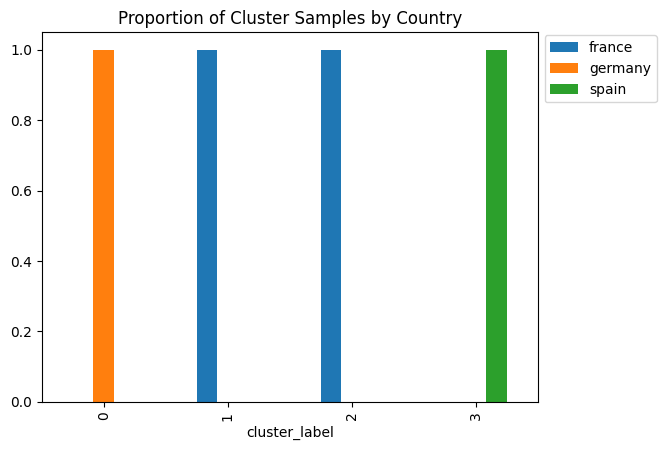

gender           female      male
cluster_label                    
0              0.475488  0.524512
1              0.445951  0.554049
2              0.458071  0.541929
3              0.439645  0.560355


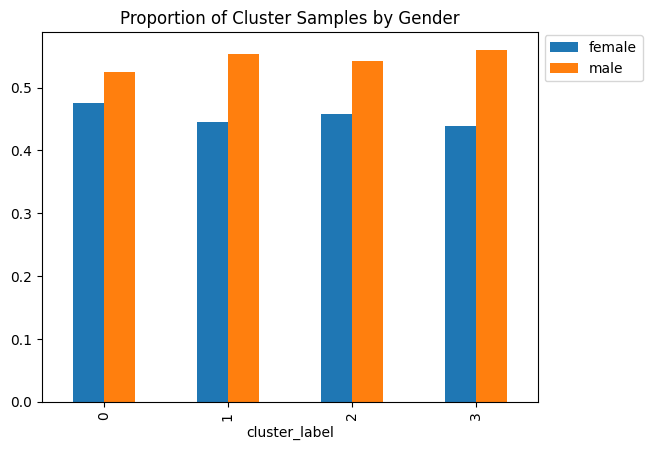

hascrcard             0         1
cluster_label                    
0              0.286170  0.713830
1              0.294476  0.705524
2              0.291808  0.708192
3              0.305208  0.694792


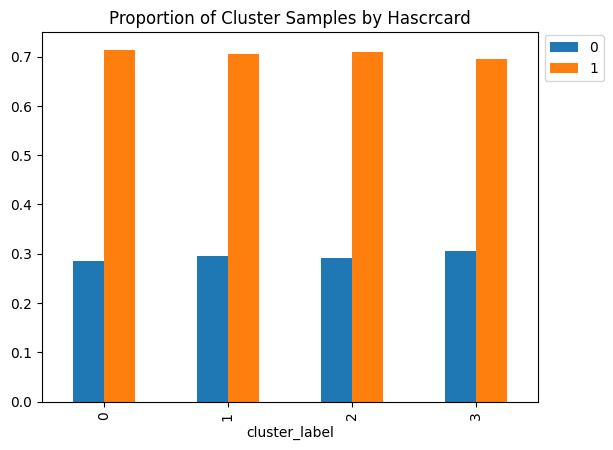

isactivemember         0         1
cluster_label                     
0               0.502591  0.497409
1               0.500169  0.499831
2               0.459040  0.540960
3               0.470327  0.529673


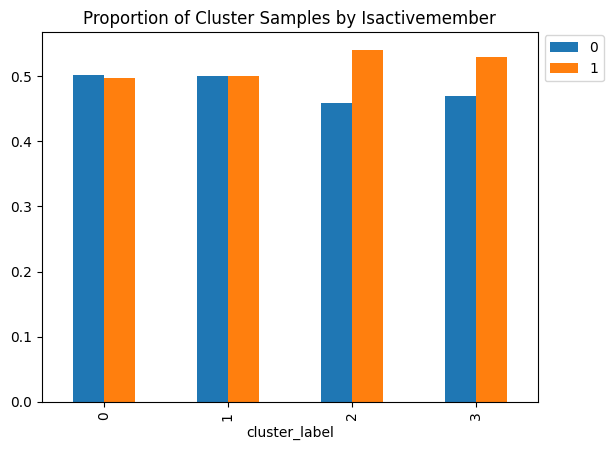

In [17]:
for col in categorical_cols:
    norm_counts = pd.crosstab(df_clustered[col], df_clustered["cluster_label"], normalize="columns").T
    print(norm_counts)
    norm_counts.plot(kind="bar")
    plt.title(f"Proportion of Cluster Samples by {col.title()}")
    plt.legend(bbox_to_anchor=[1, 1.01])
    plt.show()

### Visualize the clusters

In [18]:
from sklearn.decomposition import PCA

In [19]:
pca = PCA(2)
pca.fit(X_processed_scaled)

PCA(n_components=2)

In [20]:
pca.explained_variance_ratio_

array([0.1554941 , 0.12535425])

In [21]:
df_pca = pca.transform(X_processed_scaled)
df_pca.head()

,pca0,pca1
0,-1.399128,-0.582200
1,0.656222,1.714658
2,-0.769508,-0.734659
3,-1.682327,-0.258430
4,1.001920,1.521599


<Axes: xlabel='pca0', ylabel='pca1'>

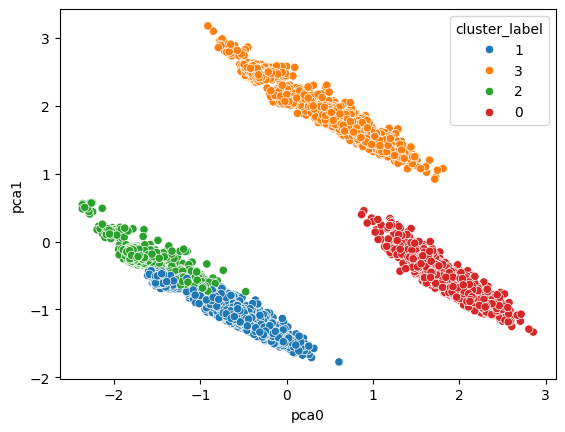

In [22]:
sns.scatterplot(x=df_pca["pca0"], y=df_pca["pca1"], hue=df_clustered["cluster_label"].astype(str))

### Check mutual info between exited and cluster_label

In [23]:
from sklearn.metrics import mutual_info_score

In [24]:
mutual_info_score(df_clustered["exited"], df_clustered["cluster_label"])

np.float64(0.020347311817967215)

## Key Takeaways

* The optimal number of clusters for the dataset is 4.

* Only balance and number of products columns seem to have a noticeable difference in average values.

* Customers in cluster 2 seem to have a very low balance compared to other customers.

* Customers in cluster 0 seem to have the highest churn rate, 32%, followed by customers in clusters 1, 3, and 2 with churn rates of 20%, 17%, and 9%, respectively.

* Customers in cluster 0 are from Germany, customers in cluster 1 and cluster 2 are from France, and customers in cluster 3 are from Spain.